# The Indian 60/40 equity/bond portfolio

In [1]:
library(tidyverse)
library(ggthemes)
library(odbc)
library(plutoR)
library(quantmod)
library(PerformanceAnalytics)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")
source("goofy/misc.common.R")

indices <- Indices()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend

Registering fonts with R

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package

In [2]:
# what are the begin and end dates that we have bond info for?

indices$IndiaGsecTimeSeries() %>%
    group_by(NAME) %>%
    summarize(ST = min(TIME_STAMP), ET = max(TIME_STAMP)) %>%
    print()

Warning message:
“Missing values are always removed in SQL.
Use `MIN(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”Warning message:
“Missing values are always removed in SQL.
Use `MAX(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”

# Source:   lazy query [?? x 3]
# Database: Microsoft SQL Server 13.00.4224[ro1@NORWAY/StockViz]
  NAME  ST         ET        
  <chr> <date>     <date>    
1 0_5   2003-12-31 2019-07-10
2 10_15 2003-12-31 2019-07-10
3 15_20 2003-12-31 2019-07-10
4 20_30 2003-12-31 2019-07-10
5 5_10  2003-12-31 2019-07-10


In [3]:
# what are the begin and end dates that we have equity index info for?

indicesOfInterest <- c('NIFTY 50 TR', 'NIFTY MIDCAP 100 TR', 'NIFTY MIDCAP 150 TR')

indices$NseTimeSeries() %>%
    filter(NAME %in% indicesOfInterest) %>%
    group_by(NAME) %>%
    summarize(ST = min(TIME_STAMP), ET = max(TIME_STAMP)) %>%
    print()

# Source:   lazy query [?? x 3]
# Database: Microsoft SQL Server 13.00.4224[ro1@NORWAY/StockViz]
  NAME                ST         ET        
  <chr>               <date>     <date>    
1 NIFTY 50 TR         1999-06-30 2019-07-10
2 NIFTY MIDCAP 100 TR 2003-01-01 2019-07-10
3 NIFTY MIDCAP 150 TR 2005-04-01 2019-07-10


In [4]:
startDate <- as.Date('2004-01-01')
endDate <- as.Date('2019-06-30')

eqIndex1 <- "NIFTY 50 TR" 
eqIndex2 <- "NIFTY MIDCAP 100 TR" # maximum overlap is for MIDCAP 100 TR

bndIndex <- '0_5' #gsec. shortest tenure

eqDt1 <- indices$NseTimeSeries() %>%
    filter(NAME == eqIndex1 & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect()

eqDt2 <- indices$NseTimeSeries() %>%
    filter(NAME == eqIndex2 & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect()

bndDt <- indices$IndiaGsecTimeSeries() %>%
    filter(NAME == bndIndex & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(TIME_STAMP, TRI) %>%
    collect()

eqXts1 <- Common.NormalizeMonthlyDates(monthlyReturn(xts(eqDt1$CLOSE, eqDt1$TIME_STAMP)))
eqXts2 <- Common.NormalizeMonthlyDates(monthlyReturn(xts(eqDt2$CLOSE, eqDt2$TIME_STAMP)))
bndXts <- Common.NormalizeMonthlyDates(monthlyReturn(xts(bndDt$TRI, bndDt$TIME_STAMP)))

port1 <- eqXts1*0.6 + bndXts*0.4
port2 <- eqXts2*0.6 + bndXts*0.4

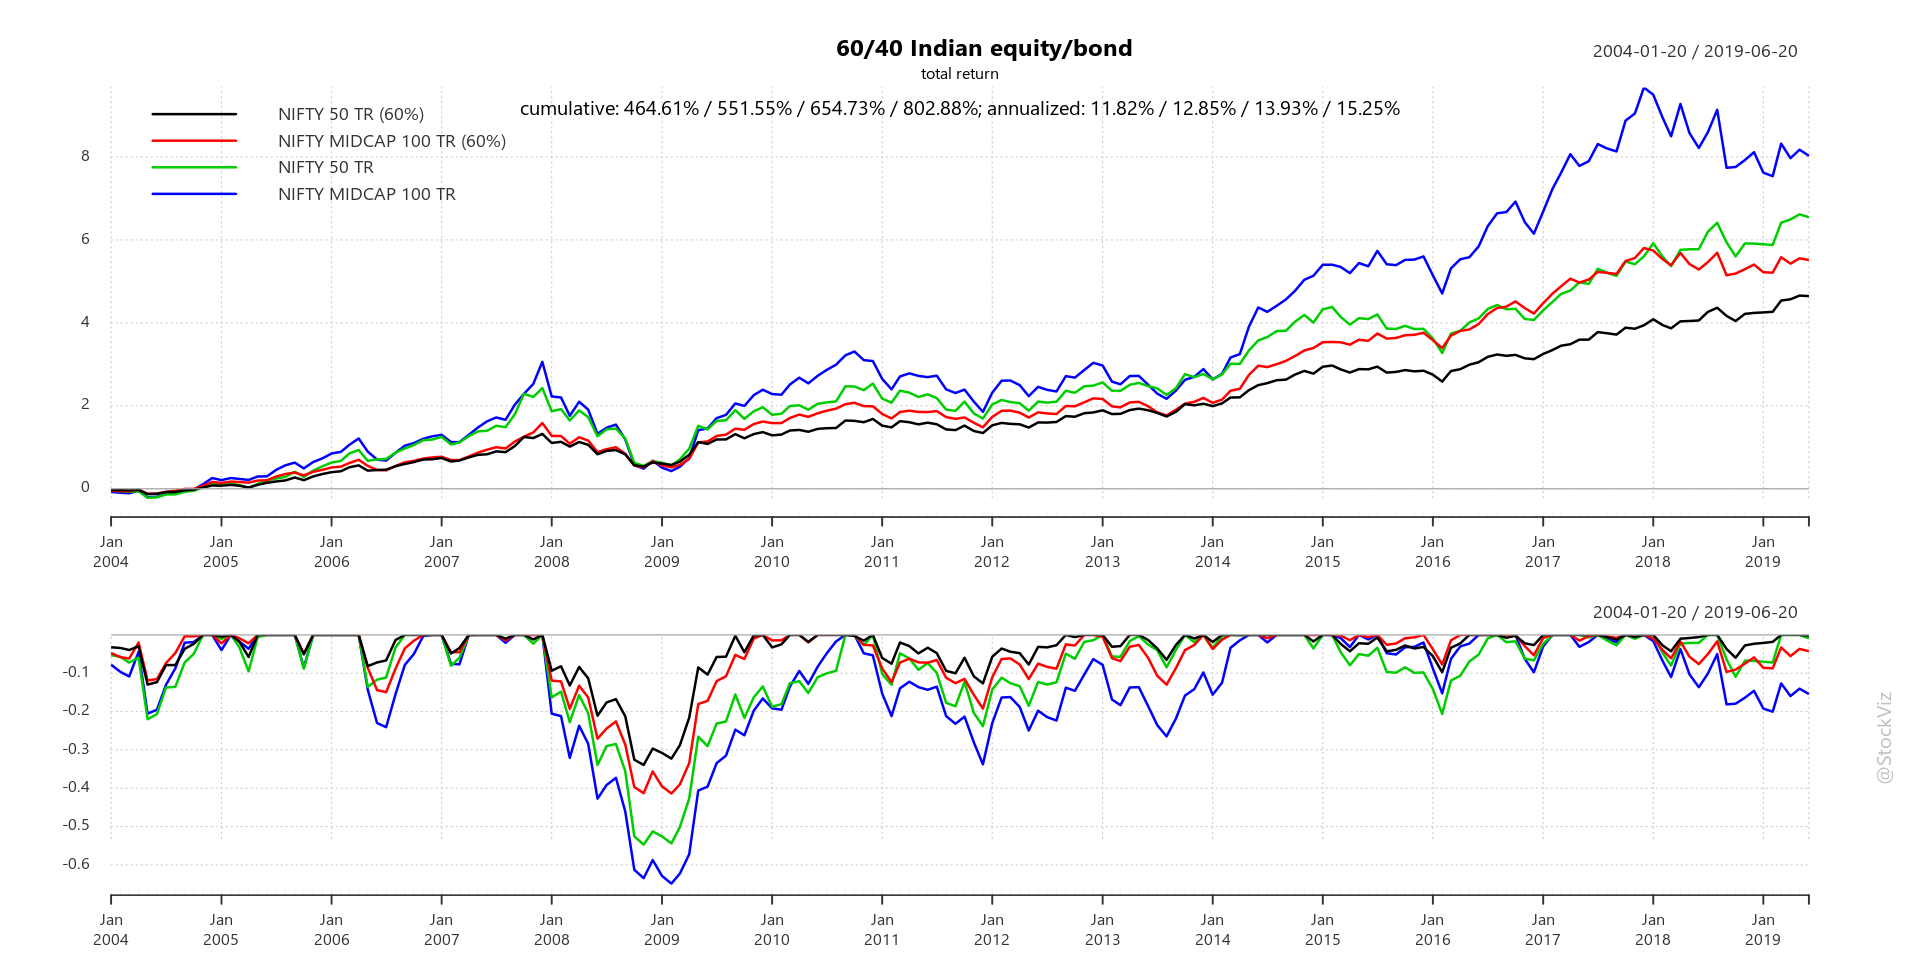

In [5]:
#plot the different scenarios
port2plot <- merge(port1, port2, eqXts1, eqXts2)
names(port2plot) <- c(sprintf("%s (60%%)", eqIndex1), sprintf("%s (60%%)", eqIndex2), eqIndex1, eqIndex2)
Common.PlotCumReturns(port2plot, "60/40 Indian equity/bond", "total return")

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)